<a href="https://colab.research.google.com/github/sjunc/AI-Library/blob/main/class/W10_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W10 - AutoEncoder

<ipython-input-17-b816022c4033>:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  gaussian_data_x = x + np.random.normal(
<ipython-input-17-b816022c4033>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)         # 파이토치 텐서로 변환


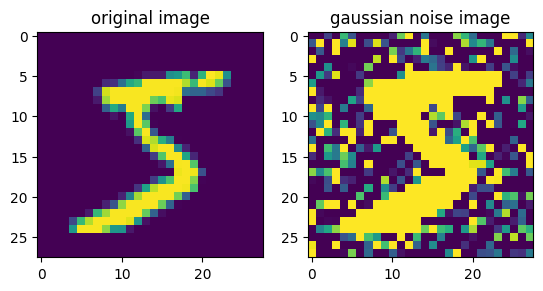

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

def gaussian_noise(x, scale = 0.8):   # 이미지에 가우시안 노이즈를 추가하는 함수
    gaussian_data_x = x + np.random.normal(
        loc = 0,        # 평균이 0이고
        scale = scale,  # 표준편차 scale인 (기본값 0.8)
        size = x.shape) # 입력 이미지와 같은 크기의 가우시안 노이즈를 생성하여 더함

    gaussian_data_x = np.clip(
        gaussian_data_x, 0, 1)    # 노이즈 추가 후, 값이 0~1 범위를 넘지 않도록 클리핑
        # 여기에서 0 미만, 1 초과되는 이상치를 제거함

    gaussian_data_x = torch.tensor(gaussian_data_x)         # 파이토치 텐서로 변환
    gaussian_data_x = gaussian_data_x.type(torch.FloatTensor)   # float 타입으로 명시적 변환 pytorch에서 모델에 입력되는 텐서는 float형이여야 연산 가능

    return gaussian_data_x

# 학습 데이터 정의 (MNIST 훈련용 이미지 로딩)
training_data = MNIST(
    root= "./",
    train = True,   # 훈련 데이터 불러오기
    download = True,
    transform = ToTensor()
)
# 평가 데이터 정의 (MNIST 테스트용 이미지 로딩)
test_data = MNIST(
    root = "./",
    train = False,  # 평가 데이터 불러오기
    download = True,
    transform = ToTensor()
)

# 첫번째 원본 이미지 가져오기 (텐서가 아니라 numpy 배열 형태로 저장된 원본 데이터 사용)
img = training_data.data[0] # 크기: [28, 28], 값: 0~255 (uint8) 밝기

# 잡음이 섞인 이미지로 변환 (float으로 변환하여 0~1 범위로 정규화된 이미지 생성)
gaussian = gaussian_noise(img)

# 두 이미지 출력: 원본과 노이즈 이미지 비교 시각화
plt.subplot(1, 2, 1)
plt.title("original image")
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.title("gaussian noise image")
plt.imshow(gaussian)
plt.show()


In [18]:
from logging import root
from torch.utils.data.dataset import Dataset

class Denoising(Dataset):
    def __init__(self):
      # 원본 이미지를 담고있는 MNIST 데이터
        self.mnist = MNIST(
            root = "./",
            train = True,     # 훈련데이터 사용
            download = True,
            transform = ToTensor()
        )
        self.data = []  # 잡음이 추가된 이미지들을 저장할 리스트

        # 모든 이미지에 잡음 입히기
        for i in range(len(self.mnist)):
            noisy_input = gaussian_noise(self.mnist.data[i])    # 가우시안 노이즈 추가
            input_tensor = torch.tensor(noisy_input)   # 텐서로 변환
            self.data.append(torch.unsqueeze(input_tensor, dim =0))
            # [28, 28] -> [1, 28, 28]로 차원 추가 (채널 차원), Conv2d 입력 형태에 맞추기 위함

    def __len__(self):
        return len(self.data)   # 전체 데이터 길이 반환

    def __getitem__(self, i):
        data = self.data[i] # 노이즈가 낀 이미지

        # 원본 이미지를 0~1 범위로 정규화하여 label로 사용
        label = self.mnist.data[i]/255

        return data, label  # (입력: 노이즈 이미지, 출력: 깨끗한 원본 이미지)



In [19]:
import torch.nn as nn

class BasicBlock(nn.Module):   # CNN 블록을 이용
  def __init__(self, in_channels, out_channels, hidden_dim):
    super(BasicBlock, self).__init__()

    # 첫 번째 합성곱 레이어
    self.conv1 = nn.Conv2d(
        in_channels,  # 입력 채널 수
        hidden_dim,   # 은닉 채널 수 (중간 레이어 채널)
        kernel_size = 3,   # 커널 크기 3X3 필터
        padding = 1        # 패딩 출력 크기 유지를 위해 적용
    )

    # 두 번째 합성곱 레이어
    self.conv2 = nn.Conv2d(
        hidden_dim,   # 앞 레이어의 출력이 입력 채널이 됨
        out_channels, # 이 블록의 최종 출력 채널 수
        kernel_size = 3,   # 커널 크기 3X3 필터
        padding = 1        # 패딩 출력 크기 유지를 위해 적용
    )

    # ReLU 활성화 함수
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)

    return x

In [20]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()

    # 입력 채널이 1인 것에 주의 -> 흑백 이미지이기 때문
    self.conv1 = BasicBlock(in_channels = 1, out_channels = 16, hidden_dim = 16)
    self.conv2 = BasicBlock(in_channels = 16, out_channels = 8, hidden_dim = 8)

    self.pool = nn.AvgPool2d(kernel_size = 2, stride = 2) # 2X2 평균 풀링(해상도 절반으로 줄임 )

  def forward(self, x): # 합성곱층을 거치고 풀링을 해줌
    x = self.conv1(x)   # 1채널 -> 16채널
    x = self.pool(x)    # 28 * 28 -> 14 * 14
    x = self.conv2(x)   # 16채널 -> 8채널
    x = self.pool(x)    # 14 * 14 -> 7*7

    return x


class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()

    # 디코더 입력: 8채널 * (7*7) latent vector
    self.conv1 = BasicBlock(in_channels = 8, out_channels = 8, hidden_dim = 8)
    self.conv2 = BasicBlock(in_channels = 8, out_channels = 16, hidden_dim = 16)

    # 출력층은 BasicBlock이 아닌 합성곱층 (출력 채널을 1로 맞춰줌)
    self.conv3 = nn.Conv2d(in_channels= 16, out_channels= 1, kernel_size=3, padding = 1)

    # 업샘플링
    self.upsampling1 = nn.ConvTranspose2d(8, 8, kernel_size=2, stride=2)
    self.upsampling2 = nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2)

  # 입력 크기를 키우는 업샘플링 이용
  def forward(self, x):
    # 디코더 입력값은  8 * 7 * 7
    x = self.conv1(x)
    x = self.upsampling1(x) # 7*7 -> 14 * 14
    x = self.conv2(x)
    x = self.upsampling2(x) # 14 * 14 -> 28 * 28
    x = self.conv3(x)     # 채널수 1로 줄임

    return x

class CAE(nn.Module):
  def __init__(self):
    super(CAE, self).__init__()

    self.enc = Encoder()    # 인코더 층의 정의 (입력을 latent feature로 압축)
    self.dec = Decoder()    # 디코더 층의 정의 (latent feature를 다시 원본 이미지로 복원)

  def forward(self, x):     # 인코더, 디코더를 거친 후, 채널 차원을 삭제
    x = self.enc(x)         # 입력 이미지 -> batch_size * 8 * 7 * 7
    x = self.dec(x)         # batch_size * 8 * 7 * 7 -> batch_size * 1 * 28 * 28
    x = torch.squeeze(x)    # 채널 차원 삭제: -> batch_size * 28 * 28

    return x

Using cuda device


<ipython-input-17-b816022c4033>:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  gaussian_data_x = x + np.random.normal(
<ipython-input-17-b816022c4033>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)         # 파이토치 텐서로 변환
epoch20 loss: 0.007632244378328323: 100%|██████████| 1875/1875 [00:11<00:00, 157.05it/s]


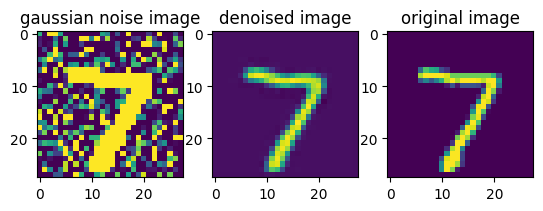

In [26]:
import tqdm

from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Denoising AutoEncoder 학습용 데이터셋 불러오기
trainset = Denoising()   # 학습에 이용할 데이터셋
train_loader = DataLoader(trainset, batch_size = 32) # 한 번에 이미지 32장 사용

# 오토인코더 모델 생성 및 GPU에 업로드
model = CAE().to(device)

# 학습률과 최적화를 정의
lr = 0.001
optim = Adam(params = model.parameters(), lr = lr)

for epoch in range(20):
  iterator = tqdm.tqdm(train_loader)

  for data, label in iterator:
    optim.zero_grad()   # 매 배치마다 기울기를 초기화해서 잘못된 방향으로 학습하지 않도록 방지
    pred = model(data.to(device))    # 모델 예측 (노이즈 -> 복원된 이미지)

    loss = nn.MSELoss()(torch.squeeze(pred), label.to(device)) # 손실의 계산
    # (픽셀 단위로 차이를 구함)
    loss.backward() # 오차 역전파
    optim.step()    # 최적화
    iterator.set_description(f"epoch{epoch+1} loss: {loss.item()}")

torch.save(model.state_dict(), "CAE.pth")  # 모델의 가중치 저장
model.cpu()   # 모델의 출력값을 cpu로 이동

with torch.no_grad():
  # 학습이 완료된 가중치를 불러오기
  model.load_state_dict(torch.load("CAE.pth", map_location = device))
  img = test_data.data[0]           # 테스트 이미지 하나 선택 (정답 이미지)
  gaussian = gaussian_noise(img)    # 이미지에 가우스 잡음을 입히기

  # 모델 입력 형태로 맞추기: [1, 1, 28, 28] 형태
  input = torch.unsqueeze(gaussian, dim =0)
  input.type(torch.FloatTensor)   # 모델과 동일한 데이터 타입 (float32) 로 변환
  input.to(device)
  input = torch.unsqueeze(input, dim =0)  # 배치 크기 1을 위한 배치 차원을 추가

  # 시각화: 왼쪽부터 (노이즈 이미지 / 복원된 이미지 / 원본 이미지 )
  plt.subplot(1, 3, 1)
  plt.title("gaussian noise image")
  plt.imshow(torch.squeeze(gaussian))
  plt.subplot(1, 3, 2)
  plt.title("denoised image")
  plt.imshow(torch.squeeze(model(input)))
  plt.subplot(1, 3, 3)
  plt.title("original image")
  plt.imshow(torch.squeeze(img))
  plt.show()